<a href="https://www.kaggle.com/code/randoeleven/monkey-pox-glcm-svm?scriptVersionId=131017405" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
import glob
glob.glob('/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/*')

['/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/Monkeypox',
 '/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/Others']

In [6]:
pd.read_csv('/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv')

ImageID          Label
0      M01_01      Monkeypox
1      M01_02      Monkeypox
2      M01_03      Monkeypox
3      M01_04      Monkeypox
4      M02_01      Monkeypox
..        ...            ...
223  NM106_01  Non Monkeypox
224  NM107_01  Non Monkeypox
225  NM108_01  Non Monkeypox
226  NM109_01  Non Monkeypox
227  NM110_01  Non Monkeypox

[228 rows x 2 columns]

In [7]:
dir_val = '/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/'
dir_test = '/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Test/'
dir_train ='/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Train/'

In [8]:
from PIL import Image

In [9]:
def img (dir):
    data=[]
    labels=[]
    imagePaths = sorted(list(os.listdir(dir)))
    for img in imagePaths:
        path=list(os.listdir(dir+img))

        for i in path:

          image = Image.open(dir+img+'/'+i).convert('L')
          image = image.resize((128,128))
          data.append(image)

          label = img
          labels.append(label)
   # df = pd.DataFrame(list(zip(data, labels)),
    #           columns =['img', 'label'])
    # ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
    properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

    glcm_all_agls = []
    for img, label in zip(data, labels): 
        glcm_all_agls.append(
                calc_glcm_all_agls(img, 
                                    label, 
                                    props=properties)
                                )

    columns = []
    angles = ['0', '45', '90','135']
    for name in properties :
        for ang in angles:
            columns.append(name + "_" + ang)

    columns.append("label")
    
    
    glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

    return glcm_df

In [10]:
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature

In [11]:
df_train = img(dir_train)
df_test = img(dir_test)
df_val = img(dir_val)

/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/opt/conda/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/opt/conda/lib/python3.7/site-packages/skimage/fea

In [12]:
df_train

dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0           17.586255         20.600481         18.490536          16.959677   
1           22.858867         23.688020         20.577998          23.655567   
2           40.939469         33.743431         23.826029          41.034599   
3            5.242569          5.491155          5.347561           5.512552   
4            9.767149          8.536681          7.844385           9.908104   
...               ...               ...               ...                ...   
2137        10.237995         10.356335         10.005208          10.492521   
2138        11.933244         11.659794          8.459096          11.386902   
2139        10.517530         10.775364          9.470020          10.571865   
2140        21.299606         25.812695         25.070630          27.106335   
2141        19.444550         23.362188         21.677973          21.703759   

      correlation_0  correlation_45  correlation_90  correlation_135  \
0          0.795073        0.717807        0.773250         0.806824   
1          0.758097        0.742691        0.782330         0.738358   
2          0.687263        0.770592        0.889425         0.693679   
3          0.620059        0.565160        0.561747         0.555331   
4          0.891831        0.931728        0.930089         0.878418   
...             ...             ...             ...              ...   
2137       0.663107        0.655732        0.688573         0.645708   
2138       0.680255        0.692865        0.862009         0.696460   
2139       0.969441        0.965972        0.975320         0.969572   
2140       0.849621        0.763937        0.767214         0.764100   
2141       0.848118        0.783756        0.820833         0.823443   

      homogeneity_0  homogeneity_45  ...  contrast_135     ASM_0    ASM_45  \
0          0.083194        0.067224  ...    576.109391  0.000188  0.000174   
1          0.066290        0.056082  ...   1199.729058  0.000141  0.000132   
2          0.088409        0.100127  ...   3399.232050  0.000398  0.000424   
3          0.202451        0.193050  ...     80.285315  0.001778  0.001731   
4          0.111339        0.127050  ...    240.529592  0.000291  0.000327   
...             ...             ...  ...           ...       ...       ...   
2137       0.113384        0.111177  ...    206.014373  0.000491  0.000499   
2138       0.103230        0.101639  ...    321.062630  0.000389  0.000393   
2139       0.099886        0.110351  ...    206.879097  0.000161  0.000160   
2140       0.051261        0.048095  ...   1314.805216  0.000101  0.000094   
2141       0.121485        0.116628  ...    999.695434  0.003886  0.002893   

        ASM_90   ASM_135  energy_0  energy_45  energy_90  energy_135  \
0     0.000184  0.000193  0.013721   0.013191   0.013547    0.013881   
1     0.000148  0.000135  0.011863   0.011471   0.012183    0.011617   
2     0.000527  0.000406  0.019953   0.020590   0.022956    0.020159   
3     0.001797  0.001751  0.042165   0.041601   0.042386    0.041840   
4     0.000358  0.000297  0.017068   0.018078   0.018934    0.017234   
...        ...       ...       ...        ...        ...         ...   
2137  0.000492  0.000482  0.022151   0.022329   0.022170    0.021947   
2138  0.000449  0.000409  0.019711   0.019834   0.021199    0.020212   
2139  0.000175  0.000159  0.012692   0.012655   0.013231    0.012626   
2140  0.000098  0.000087  0.010056   0.009680   0.009921    0.009343   
2141  0.003971  0.002863  0.062340   0.053783   0.063019    0.053503   

          label  
0     Monkeypox  
1     Monkeypox  
2     Monkeypox  
3     Monkeypox  
4     Monkeypox  
...         ...  
2137     Others  
2138     Others  
2139     Others  
2140     Others  
2141     Others  

[2142 rows x 25 columns]

In [13]:
df_train.replace(to_replace= 'Others', value = 'NonMonkeyPox', inplace=True )
df_train

dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0           17.586255         20.600481         18.490536          16.959677   
1           22.858867         23.688020         20.577998          23.655567   
2           40.939469         33.743431         23.826029          41.034599   
3            5.242569          5.491155          5.347561           5.512552   
4            9.767149          8.536681          7.844385           9.908104   
...               ...               ...               ...                ...   
2137        10.237995         10.356335         10.005208          10.492521   
2138        11.933244         11.659794          8.459096          11.386902   
2139        10.517530         10.775364          9.470020          10.571865   
2140        21.299606         25.812695         25.070630          27.106335   
2141        19.444550         23.362188         21.677973          21.703759   

      correlation_0  correlation_45  correlation_90  correlation_135  \
0          0.795073        0.717807        0.773250         0.806824   
1          0.758097        0.742691        0.782330         0.738358   
2          0.687263        0.770592        0.889425         0.693679   
3          0.620059        0.565160        0.561747         0.555331   
4          0.891831        0.931728        0.930089         0.878418   
...             ...             ...             ...              ...   
2137       0.663107        0.655732        0.688573         0.645708   
2138       0.680255        0.692865        0.862009         0.696460   
2139       0.969441        0.965972        0.975320         0.969572   
2140       0.849621        0.763937        0.767214         0.764100   
2141       0.848118        0.783756        0.820833         0.823443   

      homogeneity_0  homogeneity_45  ...  contrast_135     ASM_0    ASM_45  \
0          0.083194        0.067224  ...    576.109391  0.000188  0.000174   
1          0.066290        0.056082  ...   1199.729058  0.000141  0.000132   
2          0.088409        0.100127  ...   3399.232050  0.000398  0.000424   
3          0.202451        0.193050  ...     80.285315  0.001778  0.001731   
4          0.111339        0.127050  ...    240.529592  0.000291  0.000327   
...             ...             ...  ...           ...       ...       ...   
2137       0.113384        0.111177  ...    206.014373  0.000491  0.000499   
2138       0.103230        0.101639  ...    321.062630  0.000389  0.000393   
2139       0.099886        0.110351  ...    206.879097  0.000161  0.000160   
2140       0.051261        0.048095  ...   1314.805216  0.000101  0.000094   
2141       0.121485        0.116628  ...    999.695434  0.003886  0.002893   

        ASM_90   ASM_135  energy_0  energy_45  energy_90  energy_135  \
0     0.000184  0.000193  0.013721   0.013191   0.013547    0.013881   
1     0.000148  0.000135  0.011863   0.011471   0.012183    0.011617   
2     0.000527  0.000406  0.019953   0.020590   0.022956    0.020159   
3     0.001797  0.001751  0.042165   0.041601   0.042386    0.041840   
4     0.000358  0.000297  0.017068   0.018078   0.018934    0.017234   
...        ...       ...       ...        ...        ...         ...   
2137  0.000492  0.000482  0.022151   0.022329   0.022170    0.021947   
2138  0.000449  0.000409  0.019711   0.019834   0.021199    0.020212   
2139  0.000175  0.000159  0.012692   0.012655   0.013231    0.012626   
2140  0.000098  0.000087  0.010056   0.009680   0.009921    0.009343   
2141  0.003971  0.002863  0.062340   0.053783   0.063019    0.053503   

             label  
0        Monkeypox  
1        Monkeypox  
2        Monkeypox  
3        Monkeypox  
4        Monkeypox  
...            ...  
2137  NonMonkeyPox  
2138  NonMonkeyPox  
2139  NonMonkeyPox  
2140  NonMonkeyPox  
2141  NonMonkeyPox  

[2142 rows x 25 columns]

In [14]:
df_test

dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0         18.388338         20.326223         16.599022          19.601457   
1         18.715066         18.232895         16.865917          18.944979   
2         18.472053         17.738358         15.475292          20.462994   
3          8.534108          8.511381          8.305767           8.704800   
4         17.384654         16.442378         13.228976          17.012747   
5         26.508448         25.411681         20.576029          27.972164   
6         15.300368         17.887487         14.184769          16.457141   
7         14.127922         16.992196         16.400025          15.820044   
8         13.884972         14.621098         14.594703          15.293770   
9         13.570376         15.206296         16.802718          17.574662   
10        22.674797         22.980684         22.916286          25.127146   
11        23.726054         24.182557         19.198806          23.280437   
12        18.309832         20.410640         19.920478          20.495447   
13        22.068026         23.176184         23.209223          24.232570   
14        17.868013         16.275364         12.427973          16.933663   
15        18.971799         19.094628         18.450330          21.340010   
16        14.473450         14.343652         15.345783          17.695890   
17        15.440993         16.170851         14.804624          15.828889   
18        25.791159         29.733286         27.901359          29.930476   
19        18.620046         17.499285         15.890053          19.904527   
20         7.895008          9.223790          9.529281           8.767560   
21         3.156758          3.107830          2.602642           3.087799   
22        16.224975         12.241610         15.439215          19.496488   
23         7.768737          8.750325          7.867060           8.533169   
24        11.520770         11.167534         10.384146          11.553915   
25         3.733295          3.556777          2.861789           3.531673   
26         7.649390          7.702003          7.927464           8.754292   
27        21.636814         20.863424         15.560023          20.106009   
28         7.520960          7.613358          6.911204           7.689126   
29         9.616108          9.760991          9.428481           9.358221   
30         7.903392          8.051379          6.797383           7.365830   
31        11.828506         12.651145         12.277503          12.300013   
32         8.204776         10.269381          9.922637           8.911746   
33         9.107851          9.498244          9.432990           9.508780   
34        14.546240         13.829214         11.778138          15.073816   
35        13.450203         14.482635         15.573361          16.969888   
36         3.054243          3.307362          3.314215           3.666103   
37        12.201601         12.119147          9.682101          11.137682   
38        10.722624         12.104448         12.576918          12.754878   
39         8.791095          8.988033          7.630526           8.746293   
40         9.732978          9.976782          9.453061          10.166688   
41         7.106390          7.452263          7.062373           7.061589   
42         4.519309          4.611537          4.569931           4.686134   
43        13.402248         12.798322         13.607660          15.112643   
44         9.210302         10.994992         11.610963          11.574662   

    correlation_0  correlation_45  correlation_90  correlation_135  \
0        0.858545        0.762430        0.825509         0.797323   
1        0.463758        0.488537        0.553901         0.465906   
2        0.894889        0.884738        0.903798         0.868249   
3        0.749208        0.758950        0.776370         0.727120   
4        0.822489        0.837181        0.883215         0.82964

In [15]:
df_test.replace(to_replace= 'Others', value = 'NonMonkeyPox', inplace=True )
df_test

dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0         18.388338         20.326223         16.599022          19.601457   
1         18.715066         18.232895         16.865917          18.944979   
2         18.472053         17.738358         15.475292          20.462994   
3          8.534108          8.511381          8.305767           8.704800   
4         17.384654         16.442378         13.228976          17.012747   
5         26.508448         25.411681         20.576029          27.972164   
6         15.300368         17.887487         14.184769          16.457141   
7         14.127922         16.992196         16.400025          15.820044   
8         13.884972         14.621098         14.594703          15.293770   
9         13.570376         15.206296         16.802718          17.574662   
10        22.674797         22.980684         22.916286          25.127146   
11        23.726054         24.182557         19.198806          23.280437   
12        18.309832         20.410640         19.920478          20.495447   
13        22.068026         23.176184         23.209223          24.232570   
14        17.868013         16.275364         12.427973          16.933663   
15        18.971799         19.094628         18.450330          21.340010   
16        14.473450         14.343652         15.345783          17.695890   
17        15.440993         16.170851         14.804624          15.828889   
18        25.791159         29.733286         27.901359          29.930476   
19        18.620046         17.499285         15.890053          19.904527   
20         7.895008          9.223790          9.529281           8.767560   
21         3.156758          3.107830          2.602642           3.087799   
22        16.224975         12.241610         15.439215          19.496488   
23         7.768737          8.750325          7.867060           8.533169   
24        11.520770         11.167534         10.384146          11.553915   
25         3.733295          3.556777          2.861789           3.531673   
26         7.649390          7.702003          7.927464           8.754292   
27        21.636814         20.863424         15.560023          20.106009   
28         7.520960          7.613358          6.911204           7.689126   
29         9.616108          9.760991          9.428481           9.358221   
30         7.903392          8.051379          6.797383           7.365830   
31        11.828506         12.651145         12.277503          12.300013   
32         8.204776         10.269381          9.922637           8.911746   
33         9.107851          9.498244          9.432990           9.508780   
34        14.546240         13.829214         11.778138          15.073816   
35        13.450203         14.482635         15.573361          16.969888   
36         3.054243          3.307362          3.314215           3.666103   
37        12.201601         12.119147          9.682101          11.137682   
38        10.722624         12.104448         12.576918          12.754878   
39         8.791095          8.988033          7.630526           8.746293   
40         9.732978          9.976782          9.453061          10.166688   
41         7.106390          7.452263          7.062373           7.061589   
42         4.519309          4.611537          4.569931           4.686134   
43        13.402248         12.798322         13.607660          15.112643   
44         9.210302         10.994992         11.610963          11.574662   

    correlation_0  correlation_45  correlation_90  correlation_135  \
0        0.858545        0.762430        0.825509         0.797323   
1        0.463758        0.488537        0.553901         0.465906   
2        0.894889        0.884738        0.903798         0.868249   
3        0.749208        0.758950        0.776370         0.727120   
4        0.822489        0.837181        0.883215         0.82964

In [16]:
df_val

dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0           5.401931          5.152250          3.904345           5.185809   
1          11.664444         13.597880         11.724975          13.516454   
2          15.818725         18.387292         18.177210          17.582986   
3           6.145516          6.229383          5.608359           6.274779   
4           4.018864          4.215791          3.313516           3.671436   
..               ...               ...               ...                ...   
415         8.848323          9.259495          8.458841           9.109326   
416         9.747586          7.638072          7.131479          10.883065   
417         7.762449          7.541168          7.445694           8.089815   
418         6.080856          7.473010          7.885036           7.813866   
419        15.597116         15.667599         15.454713          15.820760   

     correlation_0  correlation_45  correlation_90  correlation_135  \
0         0.941122        0.947492        0.963420         0.942517   
1         0.793275        0.722259        0.790994         0.725649   
2         0.817674        0.756791        0.752055         0.779306   
3         0.905552        0.904177        0.917454         0.896895   
4         0.705123        0.671533        0.766389         0.719108   
..             ...             ...             ...              ...   
415       0.836422        0.820715        0.847758         0.822776   
416       0.670582        0.800036        0.904321         0.651565   
417       0.803188        0.823264        0.826630         0.789053   
418       0.816894        0.623092        0.563821         0.582296   
419       0.636649        0.639471        0.663529         0.633380   

     homogeneity_0  homogeneity_45  ...  contrast_135     ASM_0    ASM_45  \
0         0.208757        0.214206  ...     72.354904  0.001012  0.001016   
1         0.193264        0.176047  ...   1026.955970  0.002736  0.001840   
2         0.091581        0.073265  ...    628.982700  0.000197  0.000170   
3         0.171749        0.169858  ...    102.662786  0.000640  0.000621   
4         0.288881        0.275964  ...     46.560614  0.003823  0.003611   
..             ...             ...  ...           ...       ...       ...   
415       0.115504        0.109993  ...    138.653031  0.000450  0.000437   
416       0.184369        0.198247  ...    547.494407  0.001098  0.001242   
417       0.137918        0.137953  ...    129.037916  0.000670  0.000682   
418       0.194500        0.174486  ...    166.083767  0.001087  0.000981   
419       0.064212        0.067768  ...    412.548777  0.000224  0.000220   

       ASM_90   ASM_135  energy_0  energy_45  energy_90  energy_135      label  
0    0.001279  0.001047  0.031809   0.031875   0.035762    0.032355  Monkeypox  
1    0.002714  0.001804  0.052303   0.042898   0.052095    0.042469  Monkeypox  
2    0.000172  0.000175  0.014035   0.013021   0.013098    0.013220  Monkeypox  
3    0.000684  0.000645  0.025302   0.024922   0.026155    0.025400  Monkeypox  
4    0.004739  0.004337  0.061829   0.060094   0.068842    0.065859  Monkeypox  
..        ...       ...       ...        ...        ...         ...        ...  
415  0.000483  0.000454  0.021204   0.020908   0.021978    0.021301     Others  
416  0.001600  0.001058  0.033131   0.035235   0.039997    0.032528     Others  
417  0.000686  0.000660  0.025880   0.026111   0.026186    0.025699     Others  
418  0.000943  0.000931  0.032970   0.031319   0.030708    0.030508     Others  
419  0.000216  0.000222  0.014973   0.014816   0.014710    0.014891     Others  

[420 rows x 25 columns]

In [17]:
df_val.replace(to_replace= 'Others', value = 'NonMonkeyPox', inplace=True )
df_val

dissimilarity_0  dissimilarity_45  dissimilarity_90  dissimilarity_135  \
0           5.401931          5.152250          3.904345           5.185809   
1          11.664444         13.597880         11.724975          13.516454   
2          15.818725         18.387292         18.177210          17.582986   
3           6.145516          6.229383          5.608359           6.274779   
4           4.018864          4.215791          3.313516           3.671436   
..               ...               ...               ...                ...   
415         8.848323          9.259495          8.458841           9.109326   
416         9.747586          7.638072          7.131479          10.883065   
417         7.762449          7.541168          7.445694           8.089815   
418         6.080856          7.473010          7.885036           7.813866   
419        15.597116         15.667599         15.454713          15.820760   

     correlation_0  correlation_45  correlation_90  correlation_135  \
0         0.941122        0.947492        0.963420         0.942517   
1         0.793275        0.722259        0.790994         0.725649   
2         0.817674        0.756791        0.752055         0.779306   
3         0.905552        0.904177        0.917454         0.896895   
4         0.705123        0.671533        0.766389         0.719108   
..             ...             ...             ...              ...   
415       0.836422        0.820715        0.847758         0.822776   
416       0.670582        0.800036        0.904321         0.651565   
417       0.803188        0.823264        0.826630         0.789053   
418       0.816894        0.623092        0.563821         0.582296   
419       0.636649        0.639471        0.663529         0.633380   

     homogeneity_0  homogeneity_45  ...  contrast_135     ASM_0    ASM_45  \
0         0.208757        0.214206  ...     72.354904  0.001012  0.001016   
1         0.193264        0.176047  ...   1026.955970  0.002736  0.001840   
2         0.091581        0.073265  ...    628.982700  0.000197  0.000170   
3         0.171749        0.169858  ...    102.662786  0.000640  0.000621   
4         0.288881        0.275964  ...     46.560614  0.003823  0.003611   
..             ...             ...  ...           ...       ...       ...   
415       0.115504        0.109993  ...    138.653031  0.000450  0.000437   
416       0.184369        0.198247  ...    547.494407  0.001098  0.001242   
417       0.137918        0.137953  ...    129.037916  0.000670  0.000682   
418       0.194500        0.174486  ...    166.083767  0.001087  0.000981   
419       0.064212        0.067768  ...    412.548777  0.000224  0.000220   

       ASM_90   ASM_135  energy_0  energy_45  energy_90  energy_135  \
0    0.001279  0.001047  0.031809   0.031875   0.035762    0.032355   
1    0.002714  0.001804  0.052303   0.042898   0.052095    0.042469   
2    0.000172  0.000175  0.014035   0.013021   0.013098    0.013220   
3    0.000684  0.000645  0.025302   0.024922   0.026155    0.025400   
4    0.004739  0.004337  0.061829   0.060094   0.068842    0.065859   
..        ...       ...       ...        ...        ...         ...   
415  0.000483  0.000454  0.021204   0.020908   0.021978    0.021301   
416  0.001600  0.001058  0.033131   0.035235   0.039997    0.032528   
417  0.000686  0.000660  0.025880   0.026111   0.026186    0.025699   
418  0.000943  0.000931  0.032970   0.031319   0.030708    0.030508   
419  0.000216  0.000222  0.014973   0.014816   0.014710    0.014891   

            label  
0       Monkeypox  
1       Monkeypox  
2       Monkeypox  
3       Monkeypox  
4       Monkeypox  
..            ...  
415  NonMonkeyPox  
416  NonMonkeyPox  
417  NonMonkeyPox  
418  NonMonkeyPox  
419  NonMonkeyPox  

[420 rows x 25 columns]

# Preparation for SVM Classification

Make training data for classification
* df_train for training to model
* dr_test for prediction model

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder# creating initial dataframe
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df_train['label'] = labelencoder.fit_transform(df_train['label'])
df_test['label'] = labelencoder.fit_transform(df_test['label'])
df_val['label'] = labelencoder.fit_transform(df_val['label'])



In [19]:
df_train.shape

(2142, 25)

In [20]:
y_train =  np.array(df_train['label'], dtype=np.float32)
x_train =  np.array(df_train.drop('label',axis=1), dtype=np.float32)

y_test =  np.array(df_test['label'], dtype=np.float32)
x_test =  np.array(df_test.drop('label',axis=1), dtype=np.float32)

y_val =  np.array(df_val['label'], dtype=np.float32)
x_val =  np.array(df_val.drop('label',axis=1), dtype=np.float32)


In [21]:
x_train

array([[1.75862560e+01, 2.06004810e+01, 1.84905357e+01, ...,
        1.31910956e-02, 1.35466950e-02, 1.38810482e-02],
       [2.28588676e+01, 2.36880207e+01, 2.05779972e+01, ...,
        1.14713255e-02, 1.21830413e-02, 1.16173327e-02],
       [4.09394684e+01, 3.37434311e+01, 2.38260288e+01, ...,
        2.05899086e-02, 2.29558349e-02, 2.01591402e-02],
       ...,
       [1.05175304e+01, 1.07753639e+01, 9.47002029e+00, ...,
        1.26549741e-02, 1.32314451e-02, 1.26260305e-02],
       [2.12996063e+01, 2.58126945e+01, 2.50706310e+01, ...,
        9.68016405e-03, 9.92064178e-03, 9.34331398e-03],
       [1.94445496e+01, 2.33621883e+01, 2.16779728e+01, ...,
        5.37833907e-02, 6.30192384e-02, 5.35028242e-02]], dtype=float32)

In [22]:
y_train

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [23]:
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_train, y_train) 

In [24]:
svm_predictions = svm_model_linear.predict(x_test) 

In [25]:
# model accuracy for X_test 
accuracy = svm_model_linear.score(x_test, y_test) 
accuracy

0.8444444444444444

In [26]:
from sklearn.metrics import confusion_matrix 

In [27]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 
cm

array([[18,  2],
       [ 5, 20]])

In [30]:
target_names = ['Monkeypox','NonMonkeypox']

In [33]:
print(classification_report(y_test, svm_predictions, target_names=target_names))

              precision    recall  f1-score   support

   Monkeypox       0.78      0.90      0.84        20
NonMonkeypox       0.91      0.80      0.85        25

    accuracy                           0.84        45
   macro avg       0.85      0.85      0.84        45
weighted avg       0.85      0.84      0.84        45



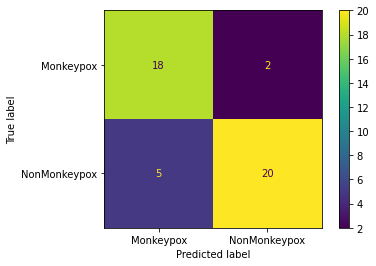

In [37]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)

cm_display.plot()
plt.show() 